# NBA player of the week

Игроки недели с 1984-1985 по 2017-2018 сезон


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import time
import warnings
%matplotlib inline

### Задача 
На датасете,используя алгоритмы ML,научиться определять,является ли игрок защитником или нападающим

In [13]:
# Загрузим датасет
# https://www.kaggle.com/jacobbaruch/nba-player-of-the-week

dataNBA = pd.read_csv('data/NBA_player_of_the_week.csv', sep = ',', engine = 'python')

In [14]:
# Выкинем менее информативные столбцы и для большей наглядности поменяем некоторые столбцы местами

dataNBA = dataNBA.drop([
    'Conference',
    'Season short',
    'Real_value',
    'Draft Year'
   ], axis=1, errors='ignore')
dataNBA = dataNBA[['Player','Age','Height','Weight','Position','Seasons in league','Season','Date','Team']]

print(dataNBA.shape) 
print(dataNBA.columns)
dataNBA.head()

(1145, 9)
Index(['Player', 'Age', 'Height', 'Weight', 'Position', 'Seasons in league',
       'Season', 'Date', 'Team'],
      dtype='object')


,Player,Age,Height,Weight,Position,Seasons in league,Season,Date,Team
0,Micheal Ray Richardson,29,6-5,189,PG,6,1984-1985,"Apr 14, 1985",New Jersey Nets
1,Derek Smith,23,6-6,205,SG,2,1984-1985,"Apr 7, 1985",Los Angeles Clippers
2,Calvin Natt,28,6-6,220,F,5,1984-1985,"Apr 1, 1985",Denver Nuggets
3,Kareem Abdul-Jabbar,37,7-2,225,C,15,1984-1985,"Mar 24, 1985",Los Angeles Lakers
4,Larry Bird,28,6-9,220,SF,5,1984-1985,"Mar 17, 1985",Boston Celtics


 - `Age` – Возраст
 - `Data` – Дата,когда выбран лучшим игроком недели
 - `Draft Year` – Год драфта
 - `Height` – Рост
 - `Player` – Имя игрока 
 - `Position` – Позиция на поле
 - `Season` – Сезон
 - `Seasons in league` – Сезонов в лиге сыграно
 - `Team` – Название команды
 - `Weight` – Вес
					

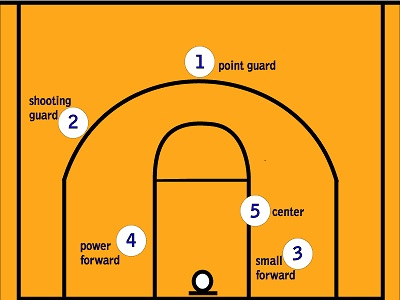

In [15]:
# Глянем картинку с позициями на поле :
from IPython.display import Image
Image("img/positions.jpg")

- PG(1)  - Разыгрывающий защитник (англ.  Point Guard), или первый номер
- SG(2)  - Атакующий защитник (англ. Shooting Guard), или второй номер
- SF(3)  - Лёгкий форвард (англ. Small Forward), или третий номер
- PF(4)  - Тяжёлый форвард (англ. Power Forward), или четвёртый номер
- C(5)   - Центровой (англ. Center), или пятый номер

Доп обозначения :
- G   - PG или  SG
- F   - SF или PF
- FC  - PF или C

In [16]:
# Определим некоторые вспомогательные функции,необходимые для приведения веса и роста к нужным единицам измерения

def convert_height(height):
    if len(re.split('cm',height)) == 1:
        height = convert_fais_to_cms(height,'-')
    else:
        height = height[:3]  # обрезаем подстроку 'cm'
    return round(int(height))

def convert_fais_to_cms(fai,delimeter): # fai - feet and inches
    # константы :
    cms_in_one_inch = 2.54
    cms_in_one_foot = 30.48 
    # перевод :
    feet,inches = re.split(delimeter,str(fai),maxsplit=1)  # макс кол-во разбиений = 1
    height_in_cms = int(feet) * cms_in_one_foot + int(inches) * cms_in_one_inch;
    return height_in_cms

def convert_weight(weight):
    lb = 0.45359237  # кг в 1-ом фунте 
    weight = re.split('kg',weight)
    if len(weight) == 1:
        weight = int(weight[0]) * lb 
    else:
        weight = int(weight[0])
    return round(weight)

In [17]:
# Проёдёмся по датасету и приведём вес к "кг",а рост к "см"

for i in range(dataNBA.shape[0]):
    dataNBA.at[i,'Height'] = convert_height(dataNBA.at[i,'Height'])
    dataNBA.at[i,'Weight'] = convert_weight(dataNBA.at[i,'Weight'])

In [18]:
# Посмотрим первые строки датасета
dataNBA.head()

,Player,Age,Height,Weight,Position,Seasons in league,Season,Date,Team
0,Micheal Ray Richardson,29,195,86,PG,6,1984-1985,"Apr 14, 1985",New Jersey Nets
1,Derek Smith,23,198,93,SG,2,1984-1985,"Apr 7, 1985",Los Angeles Clippers
2,Calvin Natt,28,198,100,F,5,1984-1985,"Apr 1, 1985",Denver Nuggets
3,Kareem Abdul-Jabbar,37,218,102,C,15,1984-1985,"Mar 24, 1985",Los Angeles Lakers
4,Larry Bird,28,205,100,SF,5,1984-1985,"Mar 17, 1985",Boston Celtics


In [19]:
# Теперь посмотрим сколько уникальных записей,проверяя по имени игрока
dataNBA.Player.unique().shape

(274,)

In [20]:
# Маловато,но что поделать.
# Теперь выкинем повторения и сравним 
dataNBA = dataNBA[~dataNBA.duplicated(subset=['Player'],keep='first')]
dataNBA.shape

(274, 9)

In [25]:
# Дропнем ненужные для дальнейшей работы колонки и посмотрим на текущее состояние датасета
dataNBA = dataNBA.drop([ 'Player',
                         'Season',
                         'Date'  ], axis=1, errors='ignore')
dataNBA

,Age,Height,Weight,Position,Seasons in league,Team
0,29,195,86,PG,6,New Jersey Nets
1,23,198,93,SG,2,Los Angeles Clippers
2,28,198,100,F,5,Denver Nuggets
3,37,218,102,C,15,Los Angeles Lakers
4,28,205,100,SF,5,Boston Celtics
5,26,193,86,SG,4,Utah Jazz
6,24,190,77,PG,2,Golden State Warriors
7,25,198,105,SF,3,Dallas Mavericks
8,25,205,116,PG,5,Los Angeles Lakers
9,25,200,91,SF,2,Atlanta Hawks


In [26]:
# Проверим типы столбцов
dataNBA.dtypes

Age                   int64
Height                int32
Weight                int32
Position             object
Seasons in league     int64
Team                 object
dtype: object

In [27]:
# Приведём вес и рост к int
dataNBA['Weight'] = dataNBA.Weight.astype(int)
dataNBA['Height'] = dataNBA.Height.astype(int)

In [28]:
# Проверим типы теперь
dataNBA.dtypes

Age                   int64
Height                int32
Weight                int32
Position             object
Seasons in league     int64
Team                 object
dtype: object

In [29]:
dataNBA.describe()

,Age,Height,Weight,Seasons in league
count,274.000000,274.000000,274.000000,274.000000
mean,25.266423,200.054745,99.364964,3.729927
std,3.065554,9.559948,13.345988,2.586252
min,19.000000,175.000000,68.000000,0.000000
25%,23.000000,193.000000,88.000000,2.000000
50%,25.000000,200.000000,100.000000,3.000000
75%,27.000000,208.000000,109.000000,5.000000
max,37.000000,228.000000,147.000000,15.000000


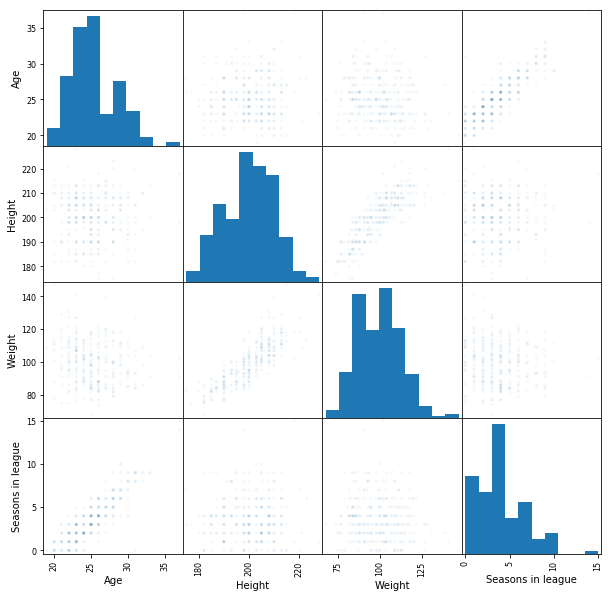

In [30]:
# Нарисуем графики числовых столбцов друг от друга
from pandas.plotting import scatter_matrix
scatter_matrix(dataNBA, alpha = .05, figsize = (10, 10))
pass

In [31]:
# Корреляция столбцов
dataNBA.corr()

,Age,Height,Weight,Seasons in league
Age,1.000000,0.025998,-0.135251,0.856909
Height,0.025998,1.000000,0.826658,0.040009
Weight,-0.135251,0.826658,1.000000,-0.085536
Seasons in league,0.856909,0.040009,-0.085536,1.000000


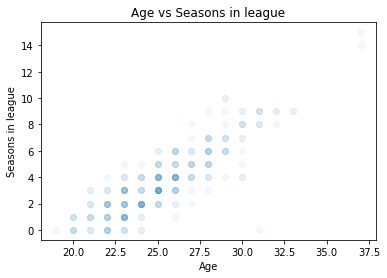

In [32]:
# Построим график зав-ти кол-ва сезонов в лиге от возраста

plt.plot(dataNBA['Age'], dataNBA['Seasons in league'], 'o', alpha = 0.05)
plt.xlabel('Age')
plt.ylabel('Seasons in league')
plt.title('Age vs Seasons in league')
pass

In [33]:
# Ближе к нашей задаче :

In [34]:
# Условно поделим игроков на защитников и нападающих
# Для этого сначала уберём игроков с позицией 'GF' или 'G-F' - это универсалы,которые играют(ли) как в защите,
# так и в нападении.

dataNBA = dataNBA[(dataNBA.Position != 'GF') & (dataNBA.Position != 'G-F')] 

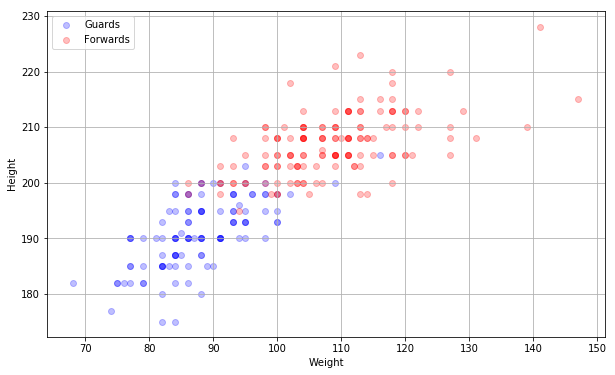

In [35]:
# Теперь все игроков с позициями  'PG','SG','G' "запишем" в защитники,
# а с позициями 'SF','PF','F','C','FC','F-C' в нападающие
# Посмотрим для нападающих и защитников зависимость роста от веса

G = dataNBA[(dataNBA['Position'] == 'PG' ) | 
            (dataNBA['Position'] == 'SG' ) | 
            (dataNBA['Position'] == 'G'  ) ]

F = dataNBA[(dataNBA['Position'] == 'SF' ) |
            (dataNBA['Position'] == 'PF' ) |
            (dataNBA['Position'] == 'F'  ) | 
            (dataNBA['Position'] == 'C'  ) |
            (dataNBA['Position'] == 'FC' ) |
            (dataNBA['Position'] == 'F-C'  )]
            
plt.figure(figsize = (10, 6)) 
plt.scatter(G['Weight'],G['Height'],
            alpha = 0.25,
            label = 'Guards',
            color = 'b')

plt.scatter(F['Weight'],F['Height'],
            alpha = 0.25,
            label = 'Forwards',
            color = 'r')

plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()
plt.grid()

In [36]:
dataNBA.describe(include = ['object']) # Признаки с типом object 

,Position,Team
count,259,259
unique,9,35
top,G,Milwaukee Bucks
freq,45,14


In [37]:
dataNBA.describe(include = 'all') # Все признаки

,Age,Height,Weight,Position,Seasons in league,Team
count,259.000000,259.000000,259.000000,259,259.000000,259
unique,NaN,NaN,NaN,9,NaN,35
top,NaN,NaN,NaN,G,NaN,Milwaukee Bucks
freq,NaN,NaN,NaN,45,NaN,14
mean,25.266409,200.015444,99.386100,NaN,3.710425,NaN
std,3.104521,9.815732,13.694534,NaN,2.600896,NaN
min,19.000000,175.000000,68.000000,NaN,0.000000,NaN
25%,23.000000,193.000000,88.000000,NaN,2.000000,NaN
50%,25.000000,200.000000,100.000000,NaN,3.000000,NaN
75%,27.000000,208.000000,109.000000,NaN,5.000000,NaN


In [38]:
dataNBA['Team'].unique()  # Уникальные команды

array(['New Jersey Nets', 'Los Angeles Clippers', 'Denver Nuggets',
       'Los Angeles Lakers', 'Boston Celtics', 'Utah Jazz',
       'Golden State Warriors', 'Dallas Mavericks', 'Atlanta Hawks',
       'Washington Bullets', 'Chicago Bulls', 'Cleveland Cavaliers',
       'Detroit Pistons', 'Milwaukee Bucks', 'Seattle SuperSonics',
       'New York Knicks', 'Philadelphia Sixers', 'Phoenix Suns',
       'Indiana Pacers', 'Portland Trail Blazers', 'San Antonio Spurs',
       'Sacramento Kings', 'Houston Rockets', 'Miami Heat',
       'Orlando Magic', 'Charlotte Hornets', 'Minnesota Timberwolves',
       'Toronto Raptors', 'Washington Wizards', 'New Orleans Hornets',
       'Memphis Grizzlies', 'Charlotte Bobcats', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

# Задача

In [39]:
# Поделим колонки на категориальные и числовые
categorical_columns = [c for c in dataNBA.columns if dataNBA[c].dtype.name == 'object'] #
numerical_columns   = [c for c in dataNBA.columns if dataNBA[c].dtype.name != 'object']
print('категориальные : ',categorical_columns)
print('числовые : ',numerical_columns)

категориальные :  ['Position', 'Team']
числовые :  ['Age', 'Height', 'Weight', 'Seasons in league']


In [40]:
for c in categorical_columns:
    print(c, dataNBA[c].unique())

Position ['PG' 'SG' 'F' 'C' 'SF' 'PF' 'G' 'FC' 'F-C']
Team ['New Jersey Nets' 'Los Angeles Clippers' 'Denver Nuggets'
 'Los Angeles Lakers' 'Boston Celtics' 'Utah Jazz' 'Golden State Warriors'
 'Dallas Mavericks' 'Atlanta Hawks' 'Washington Bullets' 'Chicago Bulls'
 'Cleveland Cavaliers' 'Detroit Pistons' 'Milwaukee Bucks'
 'Seattle SuperSonics' 'New York Knicks' 'Philadelphia Sixers'
 'Phoenix Suns' 'Indiana Pacers' 'Portland Trail Blazers'
 'San Antonio Spurs' 'Sacramento Kings' 'Houston Rockets' 'Miami Heat'
 'Orlando Magic' 'Charlotte Hornets' 'Minnesota Timberwolves'
 'Toronto Raptors' 'Washington Wizards' 'New Orleans Hornets'
 'Memphis Grizzlies' 'Charlotte Bobcats' 'Oklahoma City Thunder'
 'Brooklyn Nets' 'New Orleans Pelicans']


In [41]:
# Медианы числовых колонок
dataNBA.median(axis = 0)

Age                   25.0
Height               200.0
Weight               100.0
Seasons in league      3.0
dtype: float64

In [42]:
# Заполним медианами возможные NA значания
dataNBA = dataNBA.fillna(dataNBA.median(axis = 0), axis = 0)

In [43]:
dataNBA[numerical_columns].count(axis=0)

Age                  259
Height               259
Weight               259
Seasons in league    259
dtype: int64

In [44]:
dataNBA[categorical_columns].count(axis = 0)

Position    259
Team        259
dtype: int64

In [45]:
dataNBA['Position'].unique()

array(['PG', 'SG', 'F', 'C', 'SF', 'PF', 'G', 'FC', 'F-C'], dtype=object)

In [46]:
# Сделаем колонку 'Position' бинарной - защитников обозначим за 0,нападающих за 1

dataNBA.at[(dataNBA['Position'] == 'PG' ) | 
           (dataNBA['Position'] == 'SG' ) | 
           (dataNBA['Position'] == 'G'  ), 'Position'] = 0


dataNBA.at[(dataNBA['Position'] == 'SF' ) |
           (dataNBA['Position'] == 'PF' ) |
           (dataNBA['Position'] == 'F'  ) | 
           (dataNBA['Position'] == 'C'  ) |
           (dataNBA['Position'] == 'FC' ) |
           (dataNBA['Position'] == 'F-C'  ),'Position'] = 1
dataNBA['Position'].describe()

count     259
unique      2
top         1
freq      147
Name: Position, dtype: int64

# Векторизация
Нужно что-то сделать с категориальными (номинальными) признаками

In [47]:
dataNBA_describe = dataNBA.describe(include =[object])
binary_columns = [c for c in categorical_columns if dataNBA_describe[c]['unique']==2]
nonbinary_columns = [c for c in categorical_columns if dataNBA_describe[c]['unique']>2]
print ('Бинарные- ',binary_columns)
print ('Небинарные- ',nonbinary_columns)

Бинарные-  ['Position']
Небинарные-  ['Team']


In [48]:
dataNBA_nonbinary = pd.get_dummies(dataNBA[nonbinary_columns])
print(dataNBA_nonbinary.columns)

Index(['Team_Atlanta Hawks', 'Team_Boston Celtics', 'Team_Brooklyn Nets',
       'Team_Charlotte Bobcats', 'Team_Charlotte Hornets',
       'Team_Chicago Bulls', 'Team_Cleveland Cavaliers',
       'Team_Dallas Mavericks', 'Team_Denver Nuggets', 'Team_Detroit Pistons',
       'Team_Golden State Warriors', 'Team_Houston Rockets',
       'Team_Indiana Pacers', 'Team_Los Angeles Clippers',
       'Team_Los Angeles Lakers', 'Team_Memphis Grizzlies', 'Team_Miami Heat',
       'Team_Milwaukee Bucks', 'Team_Minnesota Timberwolves',
       'Team_New Jersey Nets', 'Team_New Orleans Hornets',
       'Team_New Orleans Pelicans', 'Team_New York Knicks',
       'Team_Oklahoma City Thunder', 'Team_Orlando Magic',
       'Team_Philadelphia Sixers', 'Team_Phoenix Suns',
       'Team_Portland Trail Blazers', 'Team_Sacramento Kings',
       'Team_San Antonio Spurs', 'Team_Seattle SuperSonics',
       'Team_Toronto Raptors', 'Team_Utah Jazz', 'Team_Washington Bullets',
       'Team_Washington Wizards'],
 

# Нормализация количественных признаков

In [49]:
dataNBA_numerical = dataNBA[numerical_columns]
dataNBA_numerical.describe()

,Age,Height,Weight,Seasons in league
count,259.000000,259.000000,259.000000,259.000000
mean,25.266409,200.015444,99.386100,3.710425
std,3.104521,9.815732,13.694534,2.600896
min,19.000000,175.000000,68.000000,0.000000
25%,23.000000,193.000000,88.000000,2.000000
50%,25.000000,200.000000,100.000000,3.000000
75%,27.000000,208.000000,109.000000,5.000000
max,37.000000,228.000000,147.000000,15.000000


In [50]:
dataNBA_numerical = (dataNBA_numerical - dataNBA_numerical.mean(axis = 0))/dataNBA_numerical.std(axis = 0)

In [51]:
dataNBA_numerical.describe()

,Age,Height,Weight,Seasons in league
count,2.590000e+02,2.590000e+02,2.590000e+02,2.590000e+02
mean,2.177580e-16,-2.829140e-16,3.403541e-16,2.186153e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.018478e+00,-2.548505e+00,-2.291871e+00,-1.426595e+00
25%,-7.300350e-01,-7.147143e-01,-8.314339e-01,-6.576291e-01
50%,-8.581331e-02,-1.573394e-03,4.482808e-02,-2.731462e-01
75%,5.584084e-01,8.134448e-01,7.020246e-01,4.958197e-01
max,3.779517e+00,2.850990e+00,3.476854e+00,4.340649e+00


In [52]:
dataNBA = pd.concat((dataNBA_numerical, dataNBA_nonbinary, dataNBA[binary_columns]), axis = 1)
dataNBA.describe()

,Age,Height,Weight,Seasons in league,Team_Atlanta Hawks,Team_Boston Celtics,Team_Brooklyn Nets,Team_Charlotte Bobcats,Team_Charlotte Hornets,Team_Chicago Bulls,...,Team_Philadelphia Sixers,Team_Phoenix Suns,Team_Portland Trail Blazers,Team_Sacramento Kings,Team_San Antonio Spurs,Team_Seattle SuperSonics,Team_Toronto Raptors,Team_Utah Jazz,Team_Washington Bullets,Team_Washington Wizards
count,2.590000e+02,2.590000e+02,2.590000e+02,2.590000e+02,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,...,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,2.177580e-16,-2.829140e-16,3.403541e-16,2.186153e-17,0.034749,0.038610,0.003861,0.007722,0.015444,0.023166,...,0.034749,0.027027,0.030888,0.027027,0.034749,0.027027,0.015444,0.038610,0.015444,0.034749
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.183498,0.193037,0.062137,0.087704,0.123549,0.150722,...,0.183498,0.162476,0.173349,0.162476,0.183498,0.162476,0.123549,0.193037,0.123549,0.183498
min,-2.018478e+00,-2.548505e+00,-2.291871e+00,-1.426595e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.300350e-01,-7.147143e-01,-8.314339e-01,-6.576291e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.581331e-02,-1.573394e-03,4.482808e-02,-2.731462e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.584084e-01,8.134448e-01,7.020246e-01,4.958197e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.779517e+00,2.850990e+00,3.476854e+00,4.340649e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
dataNBA['Position'] = dataNBA.Position.astype(int)

# X и y

In [54]:
# Выкинем столбец 'Position'
X = dataNBA.drop(('Position'), axis = 1)
y = dataNBA['Position']
feature_names = X.columns
feature_names

Index(['Age', 'Height', 'Weight', 'Seasons in league', 'Team_Atlanta Hawks',
       'Team_Boston Celtics', 'Team_Brooklyn Nets', 'Team_Charlotte Bobcats',
       'Team_Charlotte Hornets', 'Team_Chicago Bulls',
       'Team_Cleveland Cavaliers', 'Team_Dallas Mavericks',
       'Team_Denver Nuggets', 'Team_Detroit Pistons',
       'Team_Golden State Warriors', 'Team_Houston Rockets',
       'Team_Indiana Pacers', 'Team_Los Angeles Clippers',
       'Team_Los Angeles Lakers', 'Team_Memphis Grizzlies', 'Team_Miami Heat',
       'Team_Milwaukee Bucks', 'Team_Minnesota Timberwolves',
       'Team_New Jersey Nets', 'Team_New Orleans Hornets',
       'Team_New Orleans Pelicans', 'Team_New York Knicks',
       'Team_Oklahoma City Thunder', 'Team_Orlando Magic',
       'Team_Philadelphia Sixers', 'Team_Phoenix Suns',
       'Team_Portland Trail Blazers', 'Team_Sacramento Kings',
       'Team_San Antonio Spurs', 'Team_Seattle SuperSonics',
       'Team_Toronto Raptors', 'Team_Utah Jazz', 'Team_Wa

In [55]:
print(X.shape)
print(y.shape)
N, d = X.shape

(259, 39)
(259,)


In [56]:
type(X)

pandas.core.frame.DataFrame

In [57]:
type(y)

pandas.core.series.Series

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

181 78


In [59]:
181 + 78

259

#  KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [61]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print(err_train, err_test)

0.0497237569061 0.153846153846


In [62]:
err_test = 1 - knn.score(X_test, y_test)
err_test

0.15384615384615385

In [63]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[28  5]
 [ 7 38]]


In [64]:
confusion_matrix([0,1,0,1,0], [0,1,0,0,0])

array([[3, 0],
       [1, 1]], dtype=int64)

### Подбор оптимального кол-ва соседей для метода

In [65]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print('лучшая ошибка',best_cv_err)
print('лучшее кол-во соседей из представленных - ',best_n_neighbors)

лучшая ошибка 0.0497237569061
лучшее кол-во соседей из представленных -  25


In [66]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.0552486187845 0.0769230769231


Было : 0.153846153846 (при n_neighbors = 10)

Стало : 0.0769230769231 (при n_neighbors = 25)